In [1]:
!pip install -q medmnist
# !pip install -q tensorflow
# !pip install -q scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import f1_score
import medmnist
from medmnist import INFO, Evaluator
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import tensorflow as tf

# Check for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable dynamic memory allocation for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs found: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Please select a GPU runtime in the Kaggle Notebook settings.")

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Enable mixed precision training to reduce memory usage
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Set target image size and batch size
TARGET_SIZE = (32, 32)   # Use a low resolution
BATCH_SIZE = 16

In [5]:
def load_npz_data(npz_path):
    """
    Load train, val, and test arrays from a given .npz file.
    Expected keys: 'train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels'
    """
    data = np.load(npz_path)
    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def create_tf_dataset_from_numpy(images, labels, batch_size=BATCH_SIZE, augment=False):
    """
    Convert numpy arrays to a tf.data.Dataset:
      - Resize images to TARGET_SIZE.
      - Convert grayscale images (N, H, W) or (N, H, W, 1) to 3-channel RGB.
      - Optionally apply data augmentation.
    """
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)
    if images.shape[-1] == 1:
        images = np.tile(images, (1, 1, 1, 3))
    
    images = images.astype(np.float32) / 255.0  # Normalize

    def _process(image, label):
        image = tf.image.resize(image, TARGET_SIZE)
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image, label

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(images))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [6]:
# Set base path for Kaggle data
base_path = Path("/kaggle/input/tensor-reloaded-multi-task-med-mnist/data")

# Define the 11 task names
task_names = [
    "pathmnist",
    "dermamnist",
    "octmnist",
    "pneumoniamnist",
    "retinamnist",
    "breastmnist",
    "bloodmnist",
    "tissuemnist",
    "organamnist",
    "organcmnist",
    "organsmnist"
]

# Map each task to its corresponding .npz file
task_to_npz = {task: base_path / f"{task}.npz" for task in task_names}

# Create dictionaries for train, val, and test datasets
train_datasets_tf = {}
val_datasets_tf = {}
test_datasets_tf = {}

for task in task_names:
    npz_file = task_to_npz[task]
    (train_imgs, train_lbls), (val_imgs, val_lbls), (test_imgs, test_lbls) = load_npz_data(npz_file)
    train_datasets_tf[task] = create_tf_dataset_from_numpy(train_imgs, train_lbls, BATCH_SIZE, augment=True)
    val_datasets_tf[task]   = create_tf_dataset_from_numpy(val_imgs, val_lbls, BATCH_SIZE, augment=False)
    test_datasets_tf[task]  = create_tf_dataset_from_numpy(test_imgs, test_lbls, BATCH_SIZE, augment=False)
    print(f"{task}: Loaded {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test samples")

# Verify total test samples across all tasks
total_test_samples = 0
for task in task_names:
    for images, labels in test_datasets_tf[task]:
        total_test_samples += images.shape[0]
print("Total test samples across all tasks:", total_test_samples)

pathmnist: Loaded 89996 train, 10004 val, 7180 test samples
dermamnist: Loaded 7007 train, 1003 val, 2005 test samples
octmnist: Loaded 97477 train, 10832 val, 1000 test samples
pneumoniamnist: Loaded 4708 train, 524 val, 624 test samples
retinamnist: Loaded 1080 train, 120 val, 400 test samples
breastmnist: Loaded 546 train, 78 val, 156 test samples
bloodmnist: Loaded 11959 train, 1712 val, 3421 test samples
tissuemnist: Loaded 165466 train, 23640 val, 47280 test samples
organamnist: Loaded 34581 train, 6491 val, 17778 test samples
organcmnist: Loaded 13000 train, 2392 val, 8268 test samples
organsmnist: Loaded 13940 train, 2452 val, 8829 test samples
Total test samples across all tasks: 96941


In [7]:
class MultiTaskKerasModel(keras.Model):
    def __init__(self, task_names, data_flag_to_info):
        super().__init__()
        self.task_names = task_names
        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D()
        self.flatten = layers.Flatten()
        self.heads = {}
        for task in task_names:
            n_classes = len(data_flag_to_info[task]['label'])
            self.heads[task] = layers.Dense(n_classes, name=f'head_{task}')
        self.heads = dict(self.heads)
    
    def build(self, input_shape):
        # Create a concrete shape by replacing None with 1 in the batch dimension.
        concrete_shape = (1,) + input_shape[1:]
        _ = self.call(tf.zeros(concrete_shape), training=False)
        super().build(input_shape)
    
    def call(self, x, **kwargs):
        # Accept extra keyword arguments (e.g., task, training)
        task = kwargs.get('task', None)
        training = kwargs.get('training', False)
        
        x = self.conv1(x, training=training)
        x = self.pool1(x)
        x = self.conv2(x, training=training)
        x = self.pool2(x)
        x = self.flatten(x)
        
        if task is not None:
            return self.heads[task](x)
        else:
            outputs = {}
            for t in self.task_names:
                outputs[t] = self.heads[t](x)
            return outputs

# Use MedMNIST INFO for metadata (number of classes)
data_flag_to_info = {task: INFO[task] for task in task_names}

# Instantiate and build the model with a concrete input shape.
model = MultiTaskKerasModel(task_names, data_flag_to_info)
model.build(input_shape=(None, TARGET_SIZE[0], TARGET_SIZE[1], 3))
model.summary()

Model: "multi_task_keras_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (1, 32, 32, 32)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 16, 16, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 16, 16, 64)             │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 8, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 4096)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_pathmnist (Dense)               │ (1, 9)                      │          36,873 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_dermamnist (Dense)              │ (1, 7)                      │          28,679 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_octmnist (Dense)                │ (1, 4)                      │          16,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_pneumoniamnist (Dense)          │ (1, 2)                      │           8,194 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_retinamnist (Dense)             │ (1, 5)                      │          20,485 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_breastmnist (Dense)             │ (1, 2)                      │           8,194 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_bloodmnist (Dense)              │ (1, 8)                      │          32,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_tissuemnist (Dense)             │ (1, 8)                      │          32,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_organamnist (Dense)             │ (1, 11)                     │          45,067 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_organcmnist (Dense)             │ (1, 11)                     │          45,067 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head_organsmnist (Dense)             │ (1, 11)                     │          45,067 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 338,958 (1.29 MB)

 Trainable params: 338,958 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Create a dummy input of shape (1, 32, 32, 3)
dummy_input = tf.random.normal((1, 32, 32, 3))

# Trigger a forward pass for each task to build all variables.
for t in task_names:
    _ = model(dummy_input, task=t, training=False)

# Instantiate the optimizer with a cosine decay learning rate scheduler.
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=1e-5)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Force the optimizer to register all current trainable variables by applying zero gradients.
dummy_grads_vars = [(tf.zeros_like(var), var) for var in model.trainable_variables]
optimizer.apply_gradients(dummy_grads_vars)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Early stopping parameters
total_epochs = 20
patience = 5
best_hmean_f1 = -np.inf
patience_counter = 0
best_weights = None

In [9]:
print("\nStarting Training...")
for epoch in range(total_epochs):
    print(f"\nEpoch {epoch+1}/{total_epochs}")
    epoch_loss = 0.0
    total_batches = 0
    
    # Training loop: iterate over each task
    for task in task_names:
        dataset = train_datasets_tf[task]
        for images, labels in dataset:
            with tf.GradientTape() as tape:
                outputs = model(images, task=task, training=True)
                loss_value = loss_fn(labels, outputs)
            grads = tape.gradient(loss_value, model.trainable_variables)
            grads_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]
            optimizer.apply_gradients(grads_vars)
            epoch_loss += loss_value.numpy()
            total_batches += 1
    avg_loss = epoch_loss / total_batches if total_batches > 0 else 0.0
    print(f"  Training Loss: {avg_loss:.4f}")
    
    # Validation: compute macro F1 for each task
    macro_f1_scores = {}
    for task in task_names:
        all_preds = []
        all_labels = []
        for images, labels in val_datasets_tf[task]:
            outputs = model(images, task=task, training=False)
            preds = tf.argmax(outputs, axis=1).numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        f1 = f1_score(all_labels, all_preds, average='macro')
        macro_f1_scores[task] = f1
        print(f"  {task} Macro F1: {f1:.4f}")
    
    f1_values = np.array(list(macro_f1_scores.values()))
    harmonic_mean_f1 = len(f1_values) / np.sum(1.0 / (f1_values + 1e-8))
    print(f"  Harmonic Mean Macro F1: {harmonic_mean_f1:.4f}")
    
    # Early stopping check
    if harmonic_mean_f1 > best_hmean_f1:
        best_hmean_f1 = harmonic_mean_f1
        patience_counter = 0
        best_weights = model.get_weights()
        print("  Improvement detected. Saving best model weights.")
    else:
        patience_counter += 1
        print(f"  No improvement for {patience_counter} epoch(s).")
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Restore best model weights after training
if best_weights is not None:
    model.set_weights(best_weights)
    print("Best model weights restored.")


Starting Training...

Epoch 1/20
  Training Loss: 1.0695
  pathmnist Macro F1: 0.0317
  dermamnist Macro F1: 0.1171
  octmnist Macro F1: 0.5490
  pneumoniamnist Macro F1: 0.6437
  retinamnist Macro F1: 0.3376
  breastmnist Macro F1: 0.5155
  bloodmnist Macro F1: 0.3383
  tissuemnist Macro F1: 0.2213
  organamnist Macro F1: 0.5638
  organcmnist Macro F1: 0.6717
  organsmnist Macro F1: 0.6684
  Harmonic Mean Macro F1: 0.1816
  Improvement detected. Saving best model weights.

Epoch 2/20
  Training Loss: 0.9181
  pathmnist Macro F1: 0.0329
  dermamnist Macro F1: 0.1170
  octmnist Macro F1: 0.3663
  pneumoniamnist Macro F1: 0.8457
  retinamnist Macro F1: 0.2779
  breastmnist Macro F1: 0.4708
  bloodmnist Macro F1: 0.4694
  tissuemnist Macro F1: 0.2681
  organamnist Macro F1: 0.6230
  organcmnist Macro F1: 0.7280
  organsmnist Macro F1: 0.7223
  Harmonic Mean Macro F1: 0.1869
  Improvement detected. Saving best model weights.

Epoch 3/20
  Training Loss: 0.8955
  pathmnist Macro F1: 0.0898

pathmnist: Macro F1 = 0.2437
dermamnist: Macro F1 = 0.2524
octmnist: Macro F1 = 0.3586
pneumoniamnist: Macro F1 = 0.8955
retinamnist: Macro F1 = 0.1696
breastmnist: Macro F1 = 0.6641
bloodmnist: Macro F1 = 0.6737
tissuemnist: Macro F1 = 0.3233
organamnist: Macro F1 = 0.7784
organcmnist: Macro F1 = 0.7717
organsmnist: Macro F1 = 0.7156

Harmonic Mean Macro F1 across all tasks: 0.3939


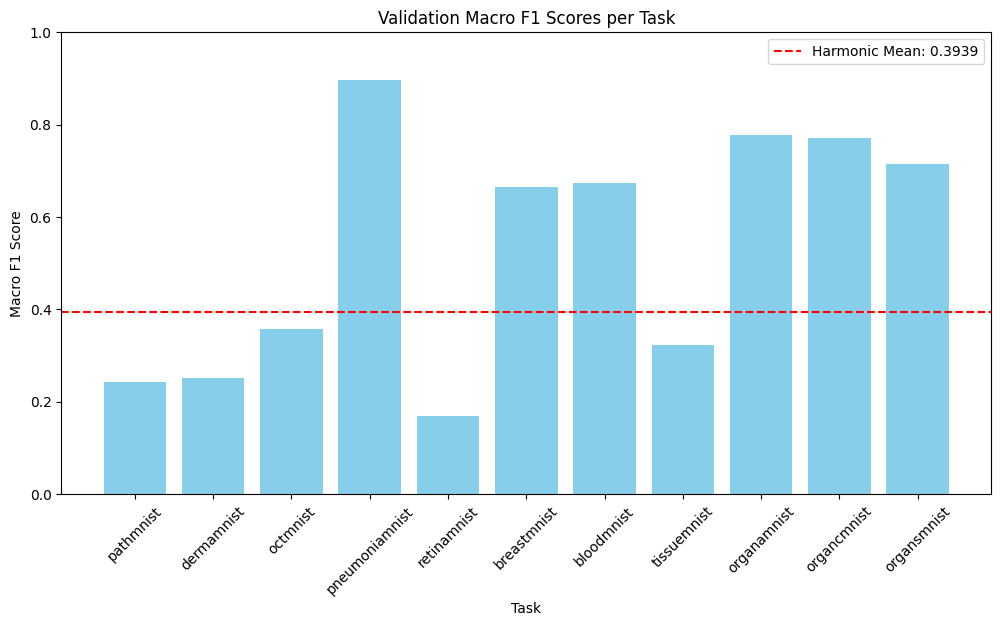

In [10]:
macro_f1_scores = {}
for task in task_names:
    all_preds = []
    all_labels = []
    for images, labels in val_datasets_tf[task]:
        outputs = model(images, task=task, training=False)
        preds = tf.argmax(outputs, axis=1).numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    f1 = f1_score(all_labels, all_preds, average='macro')
    macro_f1_scores[task] = f1
    print(f"{task}: Macro F1 = {f1:.4f}")

f1_values = np.array(list(macro_f1_scores.values()))
harmonic_mean_f1 = len(f1_values) / np.sum(1.0 / (f1_values + 1e-8))
print(f"\nHarmonic Mean Macro F1 across all tasks: {harmonic_mean_f1:.4f}")

# Plot results
tasks = list(macro_f1_scores.keys())
scores = list(macro_f1_scores.values())
plt.figure(figsize=(12,6))
plt.bar(tasks, scores, color='skyblue')
plt.axhline(y=harmonic_mean_f1, color='red', linestyle='--', label=f'Harmonic Mean: {harmonic_mean_f1:.4f}')
plt.xlabel("Task")
plt.ylabel("Macro F1 Score")
plt.title("Validation Macro F1 Scores per Task")
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.legend()
plt.show()

In [11]:
submission_rows = []
global_id = 0

for task in task_names:
    idx_in_task = 0
    for images, _ in test_datasets_tf[task]:
        outputs = model(images, task=task, training=False)
        preds = tf.argmax(outputs, axis=1).numpy()
        for pred in preds:
            submission_rows.append([global_id, idx_in_task, task, int(pred)])
            global_id += 1
            idx_in_task += 1

submission_df = pd.DataFrame(submission_rows, columns=["id", "id_image_in_task", "task_name", "label"])
print("Total submission rows:", len(submission_df))
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Total submission rows: 96941
Submission file saved as submission.csv
